Code Plan:
 * Read in and clean data
 * Determine which features are useful
 * Perform classification of snow vs rain
 * Perform linear regression of percipitation using cut data
 * Compare performance of all models
 * Create complete prediction model

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from seaborn import heatmap

Data Cleaning:
* Read data in
* Clean sheet
* Determine relevant features

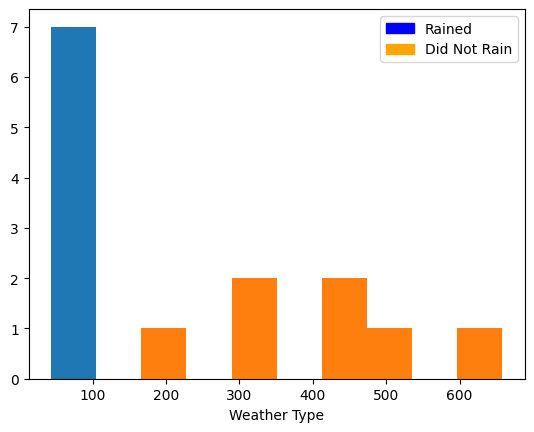

In [7]:
df = pd.read_csv("dataset.csv")
df = df.fillna(0)

# Add Liquid Precipitation and Snowfall for total snow
yr = np.asarray(df["PRCP"])
ys = np.asarray(df["SNOW"]) 
X_full = np.asarray(df.loc[:, ["AWND","PGTM","TAVG","TMAX","TMIN","WDF2","WDF5","WSF2","WSF5","WT01","WT02","WT03","WT04","WT05","WT08","WT09"]])
# Delete first day's weather and last day's data to make predictions for tomowrrow
# X_full = np.delete(X_full, -1,0)
# yr = np.delete(yr,0)
# ys = np.delete(ys,0)
y_class = np.empty(yr.shape)
for i in range(len(yr)):
    if(yr[i] == 0):
        y_class[i] = 0
    else:
        y_class[i] = 1
y = yr+ys

rain = np.empty(7)
notRain = np.empty(7)
for i in range(len(yr)):
    for j in range(9,16):
        if X_full[i][j] == 1:
            if yr[i] == 1:
                rain[j-9] +=1
            else:
                notRain[j-9] +=1
# # Legend
colors = {'Rained':'blue', 'Did Not Rain':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
#Plotting
plt.hist([rain, notRain], stacked=True)
plt.legend(handles, labels)
plt.xlabel("Weather Type")
plt.show()


scaler = StandardScaler()
X_full = scaler.fit_transform(X_full)
X_cut = np.swapaxes(X_full, 0, 1)
SPLIT_SIZE = .2
state = 425

# for num, feature in enumerate(X_cut):
#     fig = plt.figure(num)
#     plt.scatter(feature, y)
#     plt.scatter(feature, yr)
#     plt.scatter(feature, ys)
#     plt.legend(["Total", "Rain", "Snow"])
#     # plt.autoscale
#     plt.plot
#     fig.show



X_cut = np.swapaxes(X_cut, 0, 1)
# Remove Weather type booleans
X_cut = np.delete(X_cut, [9,10,11,12,13,14,15], 1)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_full, y_class, test_size = SPLIT_SIZE, random_state=state)
X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(X_train_class, y_train_class, test_size = SPLIT_SIZE, random_state=state)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_cut, yr, test_size = SPLIT_SIZE, random_state=state)
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_train_r, y_train_r, test_size = SPLIT_SIZE, random_state=state)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_cut, ys, test_size = SPLIT_SIZE, random_state=state)
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_train_s, y_train_s, test_size = SPLIT_SIZE, random_state=state)
# Note for report, no individual feature appears linear with precipitation, snowfall, or the sum.
# All features except weather type will be used in predictive models

# For each of the following models: #
* Tune Hyperparameters
* Fit model

## Classification
Determine most likely type of precipitation

Model 1: KMeans

In [ ]:
# Tune Hyperparameters
inits = ["random", "k-means++"]
for start in inits:
    kMean = KMeans(init = start, n_clusters=2, copy_x=True, random_state=state)
    kMean.fit(X_train_class, y_train_class)
    print(start, "\n   ", accuracy_score(y_train_class,kMean.predict(X_train_class)), "\n   ", accuracy_score(y_val_class,kMean.predict(X_val_class)))

# Max accuracy is k-means++ @ 66.9%

Model 2: KNN

In [ ]:
# Tune Hyperparameters
for n in range(1,22,2):
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train_class, y_train_class)
    y_predict = neigh.predict(X_val_class)
    print(n, ":   ", accuracy_score(y_val_class, y_predict))

# Max accuracy is 15 neighbors @ 90.3%

## Regression
Based on type determined by classifier, use model trained off of that type

Model 1: Linear Regression

In [ ]:
linReg = LinearRegression(copy_X=True)
linReg.fit(X_train_r, y_train_r)
lR_pred = linReg.predict(X_train_r)
print("Rain Training: \n   MSE: ", mean_squared_error(y_train_r, lR_pred), "\n   R2:  ", r2_score(y_train_r, lR_pred))
lR_pred = linReg.predict(X_val_r)
print("Rain Validation: \n   MSE: ", mean_squared_error(y_val_r, lR_pred), "\n   R2:  ", r2_score(y_val_r, lR_pred))

linReg = LinearRegression(copy_X=True)
linReg.fit(X_train_s, y_train_s)
lR_pred = linReg.predict(X_train_s)
print("Snow Training: \n   MSE: ", mean_squared_error(y_train_s, lR_pred), "\n   R2:  ", r2_score(y_train_s, lR_pred))
lR_pred = linReg.predict(X_val_s)
print("Snow Validation: \n   MSE: ", mean_squared_error(y_val_s, lR_pred), "\n   R2:  ", r2_score(y_val_s, lR_pred))

#Note for report: Validation scores are better than Training scores
# Rain .139/.007
# Snow .024/.006

Model 2: Linear SVM

In [ ]:
# Tune Hyperparameters
max_iter=[100, 1000,10000,100000]
C=[1,10,100,1000, 10000, 100000]
val_acc = []

for i in max_iter:
    for c in C:
        svm = LinearSVR(C=c, max_iter=i, random_state=state)
        svm.fit(X_train_r, y_train_r)
        val_acc.append(mean_squared_error(y_val_r, svm.predict(X_val_r)))

val_acc = np.reshape(np.asarray(val_acc), (4,6))

fig, ax = plt.subplots()
ax = heatmap(val_acc, xticklabels=C, yticklabels=max_iter, annot=True)
plt.ylabel("Max Iterations")
plt.xlabel("Regularization:")
plt.title("Heatmap of Hyperparameters")
plt.show()

# Minimum Validation MSE at 100, 10000

In [ ]:
linSVM = LinearSVR(C=100, max_iter=10000, random_state=state)
linSVM.fit(X_train_r, y_train_r)

lSVM_pred = linSVM.predict(X_train_r)
print("Rain Training: \n   MSE: ", mean_squared_error(y_train_r, lSVM_pred), "\n   R2:  ", r2_score(y_train_r, lSVM_pred))
lSVM_pred = linSVM.predict(X_val_r)
print("Rain Validation: \n   MSE: ", mean_squared_error(y_val_r, lSVM_pred), "\n   R2:  ", r2_score(y_val_r, lSVM_pred))

linSVM = LinearSVR(C=100, max_iter=10000, random_state=state)
linSVM.fit(X_train_s, y_train_s)

lSVM_pred = linSVM.predict(X_train_s)
print("Snow Training: \n   MSE: ", mean_squared_error(y_train_s, lSVM_pred), "\n   R2:  ", r2_score(y_train_s, lSVM_pred))
lSVM_pred = linSVM.predict(X_val_s)
print("Snow Validation: \n   MSE: ", mean_squared_error(y_val_s, lSVM_pred), "\n   R2:  ", r2_score(y_val_s, lSVM_pred))


# Note for report: Fails to converge, higher Validation values, negative R2
# Rain .153/-.087
# Snow .024/-.013

Model 3: Kernelized SVM

In [ ]:
#Tune Hyperparameters
kernels = ['poly', 'rbf', 'sigmoid']
gammas = ['scale', 'auto']
val_acc = []

for k in kernels:
    for g in gammas:
        svm = SVR(C=1000, kernel=k, gamma=g)
        svm.fit(X_train_r, y_train_r)
        val_acc.append(mean_squared_error(y_val_r, svm.predict(X_val_r)))

val_acc = np.reshape(np.asarray(val_acc), (3,2))

fig, ax = plt.subplots()
ax = heatmap(val_acc, xticklabels=gammas, yticklabels=kernels, annot=True)
plt.ylabel("Kernel:")
plt.xlabel("Gamma:")
plt.title("Heatmap of Hyperparameters")
plt.show()

C2 = [.01, .1, 1, 10, 100, 1000]
val_acc = []
for i in max_iter:
    for c in C2:
        svm = SVR(C=c, max_iter=i)
        svm.fit(X_train_r, y_train_r)
        val_acc.append(mean_squared_error(y_val_r, svm.predict(X_val_r)))

val_acc = np.reshape(np.asarray(val_acc), (4,6))

fig, ax = plt.subplots()
ax = heatmap(val_acc, xticklabels=C2, yticklabels=max_iter, annot=True)
plt.ylabel("Max Iterations")
plt.xlabel("Regularization:")
plt.title("Heatmap of Hyperparameters")
plt.show()



# Minimum Validation MSE at rbf, scale, 1, 1000

In [ ]:
kernSVM = SVR(C=1, max_iter=1000)
kernSVM.fit(X_train_r, y_train_r)

kSVM_pred = kernSVM.predict(X_train_r)
print("Rain Training: \n   MSE: ", mean_squared_error(y_train_r, kSVM_pred), "\n   R2:  ", r2_score(y_train_r, kSVM_pred))
kSVM_pred = kernSVM.predict(X_val_r)
print("Rain Validation: \n   MSE: ", mean_squared_error(y_val_r, kSVM_pred), "\n   R2:  ", r2_score(y_val_r, kSVM_pred))

kernSVM = SVR(C=1, max_iter=1000)
kernSVM.fit(X_train_s, y_train_s)

kSVM_pred = kernSVM.predict(X_train_s)
print("Rain Training: \n   MSE: ", mean_squared_error(y_train_s, kSVM_pred), "\n   R2:  ", r2_score(y_train_s, kSVM_pred))
kSVM_pred = kernSVM.predict(X_val_s)
print("Rain Validation: \n   MSE: ", mean_squared_error(y_val_s, kSVM_pred), "\n   R2:  ", r2_score(y_val_s, kSVM_pred))

# Note for report: 
# Rain .139/.012
# Snow .029/-.194

Model 4: Neural Network

In [ ]:
structs = [(100), (100,100), (100,100,100), (200),
(200,100), (200,100,100), (500), (500,200), (500,200,100)]
lrs = [0.0001, 0.001, 0.01, 0.1]
val_acc = []

for rate in lrs:
    for s in structs:
        nn = MLPRegressor(s, 'relu', solver ='sgd', learning_rate_init=rate, random_state=state)
        nn.fit(X_train_r, y_train_r)
        try:
            val_acc.append(mean_squared_error(y_val_r, nn.predict(X_val_r)))
        except:     #Value exceeded maximum. .25 is higher than all others, but close enough for the heat map to make color distinctions
            val_acc.append(0.25)

val_acc = np.reshape(np.asarray(val_acc), (4,9))

fig, ax = plt.subplots()
ax = heatmap(val_acc, xticklabels=structs, yticklabels=lrs, annot=True)
plt.ylabel("Learning Rate:")
plt.xlabel("Structure:")
plt.title("Heatmap of Hyperparameters")
plt.show()

# Minimum Validation MSE at .01 learning rate, with multiple tied architectures

In [ ]:
nn = MLPRegressor((500,200), 'relu', solver ='sgd', learning_rate_init=0.01, max_iter=1000)
nn.fit(X_train_r, y_train_r)

nn_pred = nn.predict(X_train_r)
print("Rain Training: \n   MSE: ", mean_squared_error(y_train_r, nn_pred), "\n   R2:  ", r2_score(y_train_r, nn_pred))
nn_pred = nn.predict(X_val_r)
print("Rain Validation: \n   MSE: ", mean_squared_error(y_val_r, nn_pred), "\n   R2:  ", r2_score(y_val_r, nn_pred))

nn = MLPRegressor((500,200), 'relu', solver ='sgd', learning_rate_init=0.01, max_iter=1000)
nn.fit(X_train_s, y_train_s)

nn_pred = nn.predict(X_train_s)
print("Snow Training: \n   MSE: ", mean_squared_error(y_train_s, nn_pred), "\n   R2:  ", r2_score(y_train_s, nn_pred))
nn_pred = nn.predict(X_val_s)
print("Snow Validation: \n   MSE: ", mean_squared_error(y_val_s, nn_pred), "\n   R2:  ", r2_score(y_val_s, nn_pred))

# Note for report: 
# Rain .134/.052
# Snow .025/-.018

Best Classifier is: K Nearest Neighbors with 15 neighbors

Best Rain Regression is: Neural Network with (500,200) and lr=.01
Best Snow Regression is: Default Linear regression

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train_class, y_train_class)

rain = MLPRegressor((500,200), 'relu', solver ='sgd', learning_rate_init=0.01, max_iter=1000)
rain.fit(X_train_r, y_train_r)

snow = LinearRegression(copy_X=True)
snow.fit(X_train_s, y_train_s)

r_scores = []
s_scores = []

for point in range(len((X_test_class))):
    X_sample = X_test_class[point].reshape(1, -1)
    if(classifier.predict(X_sample) == 1):
        #Rain
        X_sample = X_test_r[point].reshape(1, -1)
        r_scores.append(rain.predict(X_sample))
        s_scores.append(0)
        pass
    else:
        #Snow
        X_sample = X_test_s[point].reshape(1, -1)
        s_scores.append(snow.predict(X_sample))
        r_scores.append(0)
        pass

print("Rain MSE:   ", mean_squared_error(y_test_r, r_scores))
print("Snow MSE:   ", mean_squared_error(y_test_s, s_scores))